In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.listdir('../input')
import sys
import random
import json
from functools import partial
from collections import OrderedDict, Counter
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from fastai import *
from fastai.vision import *
from fastai.vision import (cnn_learner, models, get_transforms, 
                           ImageList, FloatList, ResizeMethod, imagenet_stats,
                           ClassificationInterpretation)
from fastai.vision import Learner, DatasetType
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [2]:
# effnet_pac_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
# sys.path.append(effnet_pac_path)

!pip install --upgrade efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=2be1d20f6b5bfb22ae7fbbe7d729c1030b347f12e3b372b64445ff94dfd9ede8
  Stored in directory: /tmp/.cache/pip/wheels/27/56/13/5bdaa98ca8bd7d5da65cc741987dd14391b87fa1a09081d17a
Successfully built efficientnet-pytorch


In [3]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
# !cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def quadratic_kappa(y_hat, y):
    scores = cohen_kappa_score(torch.round(y_hat), y, weights='quadratic')
    return torch.tensor(scores, device='cuda:0')

In [6]:
def load_efficientnet(model_name='efficientnet-b7', model_path=None, pretrained=True):
    model = EfficientNet.from_name(model_name, override_params={'num_classes': 1})
    if not pretrained:
        return model
    
    model_state = torch.load(model_path)
    if '_fc.weight' in model_state.keys():
        model_state.pop('_fc.weight')
        model_state.pop('_fc.bias')
        res = model.load_state_dict(model_state, strict=False)
        assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    else:
        # A basic remapping is required
        mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
        mapped_model_state = OrderedDict([
            (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
        ])
        res = model.load_state_dict(mapped_model_state, strict=False)
        # print(res)
    return model

In [7]:
bs = BATCH_SIZE = 32  # 64 # smaller batch size is better for training, but may take longer
sz = IMG_SIZE = 256

## Seed 2019

In [8]:
# SEED = 2019
# seed_everything(SEED)

In [9]:
'''
base_image_dir = '../input/aptos2019-blindness-detection/'
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
pd.set_option('display.max_colwidth', -1)
df.head()
'''

"\nbase_image_dir = '../input/aptos2019-blindness-detection/'\ntrain_dir = os.path.join(base_image_dir,'train_images/')\ndf = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))\ndf['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))\ndf = df.drop(columns=['id_code'])\ndf = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe\npd.set_option('display.max_colwidth', -1)\ndf.head()\n"

In [10]:
'''
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=360, max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.5)

data = (ImageList
    .from_df(df=df,path='./',cols='path') #get dataset from dataset
    # .split_by_rand_pct(0.2, seed=SEED) #Splitting the dataset
    .split_by_rand_pct(0.2)
    .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
    .transform(tfms, size=IMG_SIZE, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
    .databunch(bs=BATCH_SIZE, num_workers=4) #DataBunch
    .normalize(imagenet_stats) #Normalize
)
'''

"\ntfms = get_transforms(do_flip=True, flip_vert=True, \n                      max_rotate=360, max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.5)\n\ndata = (ImageList\n    .from_df(df=df,path='./',cols='path') #get dataset from dataset\n    # .split_by_rand_pct(0.2, seed=SEED) #Splitting the dataset\n    .split_by_rand_pct(0.2)\n    .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column\n    .transform(tfms, size=IMG_SIZE, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')\n    .databunch(bs=BATCH_SIZE, num_workers=4) #DataBunch\n    .normalize(imagenet_stats) #Normalize\n)\n"

In [11]:
# effnet_path = '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
# model = load_efficientnet(model_name='efficientnet-b5', model_path=effnet_path)

# learn = Learner(data, model, metrics=[quadratic_kappa]).to_fp16()

In [12]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [13]:
# learn.fit_one_cycle(4, max_lr=3e-3)

# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

# learn.fit_one_cycle(10, max_lr=1e-3)
# learn.save('seed2019-stage-2')

In [14]:
# del df, tfms, data, model, learn

## Seed 9012

In [15]:
# SEED = 9012
# seed_everything(SEED)

# base_image_dir = '../input/aptos2019-blindness-detection/'
# train_dir = os.path.join(base_image_dir,'train_images/')
# df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
# df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
# df = df.drop(columns=['id_code'])
# df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
# pd.set_option('display.max_colwidth', -1)
# df.head()

In [16]:
# tfms = get_transforms(do_flip=True, flip_vert=True, 
#                       max_rotate=360, max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.5)

# data = (ImageList
#     .from_df(df=df,path='./',cols='path') #get dataset from dataset
#     .split_by_rand_pct(0.2, seed=SEED) #Splitting the dataset
#     .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
#     .transform(tfms, size=IMG_SIZE, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
#     .databunch(bs=BATCH_SIZE, num_workers=4) #DataBunch
#     .normalize(imagenet_stats) #Normalize
# )

In [17]:
# effnet_path = '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
# model = load_efficientnet(model_name='efficientnet-b5', model_path=effnet_path)

# learn = Learner(data, model, metrics=[quadratic_kappa]).to_fp16()

In [18]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

# learn.fit_one_cycle(4, max_lr=3e-3)

# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

# learn.fit_one_cycle(10, max_lr=1e-3)
# learn.save('seed9012-stage-2')

In [19]:
# del df, tfms, data, model, learn

## Seed 1111

In [20]:
SEED = 1111
seed_everything(SEED)

In [21]:
base_image_dir = '../input/aptos2019-blindness-detection/'
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
pd.set_option('display.max_colwidth', -1)
df.head()

,diagnosis,path
0,3,../input/aptos2019-blindness-detection/train_images/33778d136069.png
1,2,../input/aptos2019-blindness-detection/train_images/15cd5f52d300.png
2,4,../input/aptos2019-blindness-detection/train_images/7efc91af4ae6.png
3,2,../input/aptos2019-blindness-detection/train_images/34723fae6475.png
4,2,../input/aptos2019-blindness-detection/train_images/aca88f566228.png


In [22]:
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=360, max_warp=0, max_zoom=1.1, max_lighting=0.1, p_lighting=0.5)

data = (ImageList
    .from_df(df=df,path='./',cols='path') #get dataset from dataset
    .split_by_rand_pct(0.2, seed=SEED) #Splitting the dataset
    .label_from_df(cols='diagnosis',label_cls=FloatList) #obtain labels from the level column
    .transform(tfms, size=IMG_SIZE, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
    .databunch(bs=BATCH_SIZE, num_workers=4) #DataBunch
    .normalize(imagenet_stats) #Normalize
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.29E-03


epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.669058,0.965385,0.798032,08:36
1,0.545190,0.832888,0.715140,08:29
2,0.435261,0.585609,0.820140,08:32
3,0.330338,0.259111,0.902286,08:29


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-06


epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.264951,0.249199,0.898835,08:22
1,0.277622,0.302384,0.881483,08:23
2,0.295619,0.385007,0.879079,08:19
3,0.299216,0.275647,0.900704,08:21
4,0.270904,0.252332,0.904017,08:21
5,0.243368,0.292182,0.879091,08:21
6,0.234717,0.242222,0.911074,08:21
7,0.203950,0.203438,0.925802,08:24
8,0.163226,0.205196,0.924278,08:22
9,0.155534,0.204972,0.921101,08:22


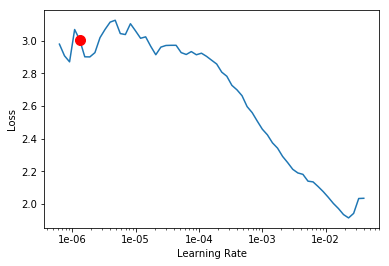

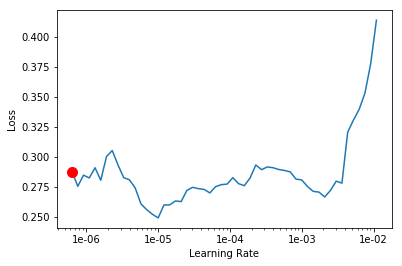

In [23]:
effnet_path = '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
model = load_efficientnet(model_name='efficientnet-b5', model_path=effnet_path)

learn = Learner(data, model, metrics=[quadratic_kappa]).to_fp16()

learn.lr_find()
learn.recorder.plot(suggestion=True)

learn.fit_one_cycle(4, max_lr=3e-3)

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

learn.fit_one_cycle(10, max_lr=1e-3)
learn.save('seed1111-stage-2')

In [24]:
# del df, tfms, data, model, learn